<a href="https://colab.research.google.com/github/ShivaniKale0/Peer2Peer_Lending_Analysis/blob/main/Team_Zeta1_Team_A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Team Assignment 3 - COMP488
3/24/2023

*Link ReadMe

0 - Mount & Access Data

In [ ]:
#0.1: Install Packages
from google.colab import drive
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import minmax_scale

#0.2: Mount Drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/488/Team Assignment 3

#0.3: Add Datasets as Dataframes
df = pd.read_csv("clean_accepted.csv")

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1Hoo_jngWwdSM0lrfX_xSNb3oGm0CnFg_/Team Assignment 3


<ipython-input-1-84da40ca8791>:14: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("clean_accepted.csv")


1 - Data Wrangling & Pre-Processing

In [ ]:
#1.1: Data Wrangling & Pre-Processing
df = df.drop(df.columns[0], axis=1)
df["fico_score"] = (df["fico_range_high"] + df["fico_range_low"])/2
df.drop(columns = ['mths_since_last_delinq', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq','sec_app_fico_range_low','sec_app_fico_range_high','debt_settlement_flag_date'] )

#1.2: Median Impute Missing Numerical Values
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
imputer = imputer.fit(df[numeric_features.tolist()])

df[numeric_features.tolist()] = imputer.transform(df[numeric_features.tolist()])

#1.3: Most-Frequent Impute Missing Categorical Values
categorical_features = df.select_dtypes(include=['object', 'category']).columns
imputercat = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')

df[categorical_features] = imputercat.fit_transform(df[categorical_features.tolist()])

2 - Calculating Baseline Expected Return

In [ ]:
#2.1: Add Total Interest Amount Column
df['total_interest'] = (df["int_rate"]/100) * df["loan_amnt"]

#2.2: Sort by Grade
df = df.sort_values('grade')

#2.3: Calculate Baseline Expected Return of $10M Investment
df["chargeoff"] = np.where(df["chargeoff_within_12_mths"] == 0, 0, 1)

count = 0
capital = 0
rev = 0
for index, row in df.iterrows():
  if (capital + row["loan_amnt"] > 10000000):
    break
  capital += row["loan_amnt"]
  if row["chargeoff"] == 0:
    rev += row["total_interest"] #FIX: Add Revenue if not Charge-Off, 0 if Charge-Off
  count += 1

print("Total Amount of Accepted Loans: " + str(count))
print("Total Amount of Money Invested: " + str(capital))
print("Total Amount: " + str(rev))

baseline_accepted = count
baseline_loan_size = capital/count
baseline_revenue = rev

Total Amount of Accepted Loans: 660
Total Amount of Money Invested: 9993400.0
Total Amount: 666703.1825


3 - Logistic Regression to Predict Charge-Off Risk

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

#3.1: Add Binary Charge-Off Column
df["chargeoff"] = np.where(df["chargeoff_within_12_mths"] == 0, 0, 1)

#3.2: Pre-Process Data for Model Creation
df2 = df.copy()
df2 = df2.drop(columns=["grade","total_rec_int","verification_status",'chargeoff_within_12_mths'])

continuous_vars = ['annual_inc','delinq_2yrs','delinq_amnt','int_rate', 'last_fico_range_high','last_fico_range_low','loan_amnt','num_accts_ever_120_pd','num_tl_120dpd_2m','num_tl_30dpd','num_tl_90g_dpd_24m','pct_tl_nvr_dlq','pub_rec','pub_rec_bankruptcies','dti'] #FIX: removed term column
df2.loc[:,continuous_vars] = minmax_scale(df[continuous_vars])

cat_cols = ['emp_length', 'term']
df2 = pd.get_dummies(df2[['chargeoff'] + continuous_vars + cat_cols], columns = cat_cols, drop_first = True)

df2.head()

,chargeoff,annual_inc,delinq_2yrs,delinq_amnt,int_rate,last_fico_range_high,last_fico_range_low,loan_amnt,num_accts_ever_120_pd,num_tl_120dpd_2m,...,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,term_ 60 months
677682,0,0.003409,0.000000,0.0,0.000389,0.869412,0.869822,0.594937,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
425950,0,0.000900,0.000000,0.0,0.054517,0.816471,0.816568,0.093671,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
425949,0,0.000227,0.000000,0.0,0.079050,0.887059,0.887574,0.430380,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
985877,0,0.000800,0.034483,0.0,0.000389,0.969412,0.970414,0.113924,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
425945,0,0.001091,0.000000,0.0,0.000000,0.981176,0.982249,0.873418,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#3.4: Split Training, Testing Data
y = df2.chargeoff
X = df2.drop(columns=['chargeoff'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

#3.5: Logistic Regression Model Construction
logreg = LogisticRegression(solver='lbfgs', C=1, tol=.0001, max_iter=1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

0.991943510205526
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    673056
           1       0.06      0.00      0.01      5155

    accuracy                           0.99    678211
   macro avg       0.53      0.50      0.50    678211
weighted avg       0.99      0.99      0.99    678211



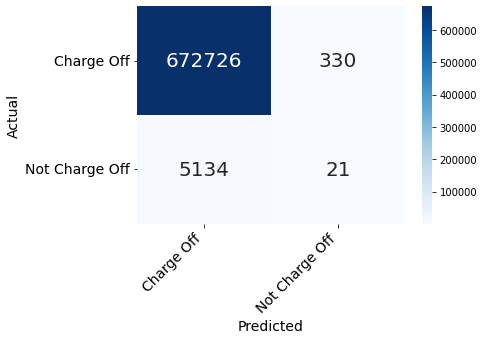

In [ ]:
#3.6: Output Logistic Regression Model Results
def show_results(y_test, y_pred):
  print(accuracy_score(y_test, y_pred))

  con_matrix = confusion_matrix(y_test, y_pred)
  confusion_matrix_df = pd.DataFrame(con_matrix, ('Charge Off', 'Not Charge Off'), ('Charge Off', 'Not Charge Off'))
  heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
  plt.ylabel('Actual', fontsize = 14)
  plt.xlabel('Predicted', fontsize = 14)

  print(classification_report(y_test, y_pred))


show_results(y_test, y_pred)



4 - Random Forest Model to Predict Charge-Off Risk

0.9923991206276512


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.99      1.00      1.00    673056
           1       0.00      0.00      0.00      5155

    accuracy                           0.99    678211
   macro avg       0.50      0.50      0.50    678211
weighted avg       0.98      0.99      0.99    678211



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


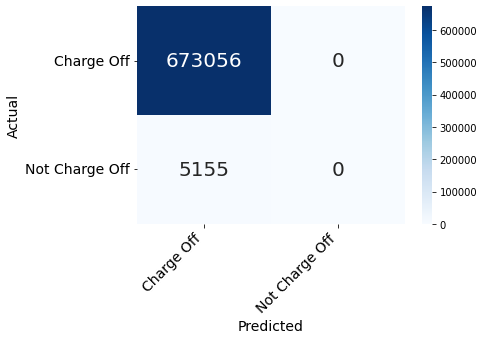

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#4.1: Random Forest Model Construction
forest = RandomForestClassifier(max_features=6, n_estimators=25, max_depth=9,random_state=21)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

#4.2: Output Random Forest Model Results
show_results(y_test, y_pred)

5 - Label as Expected HighRiskReturn

In [ ]:
#5.1: Output HighRiskReturn Label from Logistic Regression Model

array = logreg.predict_proba(df2.drop(columns=['chargeoff']))[:,0]
array_np = np.array(array)
df['logreg_Expected_Risk'] = array_np.tolist()
df['logreg_Expected_RiskReturn'] = df['logreg_Expected_Risk']*df['int_rate']
df['logreg_Expected_HighRiskReturn'] = df['logreg_Expected_RiskReturn'] > 6.67

In [ ]:
#5.2: Output HighRiskReturn Label from Random Forest Model

array = forest.predict_proba(df2.drop(columns=['chargeoff']))[:,0]
array_np = np.array(array)
df['forest_Expected_Risk'] = array_np.tolist()
df['forest_Expected_RiskReturn'] = df['forest_Expected_Risk']*df['int_rate']
df['forest_Expected_HighRiskReturn'] = df['forest_Expected_RiskReturn'] > 6.67

6 - Calculating Optimized Expected Return

In [ ]:
#6.1: Calculate Logistic Regression Optimized Expected Return of $10M Investment

highreturn_df = df[df["logreg_Expected_HighRiskReturn"] == True]
count = 0
capital = 0
rev = 0
for index, row in highreturn_df.iterrows():
  if (capital + row["loan_amnt"] > 10000000):
    break
  capital += row["loan_amnt"]
  rev += row["total_interest"]
  count += 1

print("Total Amount of Accepted Loans: " + str(count))
print("Total Amount of Money Invested: " + str(capital))
print("Total Amount: " + str(rev))

#6.2: Compute Differential
opt_accepted = count
opt_loan_size = capital/count
opt_revenue = rev

dif_accepted = opt_accepted - baseline_accepted
dif_loan_size = opt_loan_size - baseline_loan_size
dif_revenue = opt_revenue - baseline_revenue

print("Differential in Accepted Loans: " + str(dif_accepted))
print("Differential in Loan Size: " + str(dif_loan_size))
print("Differential in Amount Earned: " + str(dif_revenue))

Total Amount of Accepted Loans: 696
Total Amount of Money Invested: 9992725.0
Total Amount: 745422.3349999998
Differential in Accepted Loans: 36
Differential in Loan Size: -784.1516457680264
Differential in Amount Earned: 78719.15249999985


In [ ]:
#6.2: Calculate Random Forest Optimized Expected Return of $10M Investment

highreturn_df = df[df["forest_Expected_HighRiskReturn"] == True]
count = 0
capital = 0
rev = 0
for index, row in highreturn_df.iterrows():
  if (capital + row["loan_amnt"] > 10000000):
    break
  capital += row["loan_amnt"]
  rev += row["total_interest"]
  count += 1

print("Total Amount of Accepted Loans: " + str(count))
print("Total Amount of Money Invested: " + str(capital))
print("Total Amount: " + str(rev))

#6.2: Compute Differential
opt_accepted = count
opt_loan_size = capital/count
opt_revenue = rev

dif_accepted = opt_accepted - baseline_accepted
dif_loan_size = opt_loan_size - baseline_loan_size
dif_revenue = opt_revenue - baseline_revenue

print("Differential in Accepted Loans: " + str(dif_accepted))
print("Differential in Loan Size: " + str(dif_loan_size))
print("Differential in Amount Earned: " + str(dif_revenue))

Total Amount of Accepted Loans: 697
Total Amount of Money Invested: 9973625.0
Total Amount: 743147.3849999999
Differential in Accepted Loans: 37
Differential in Loan Size: -832.1536020173044
Differential in Amount Earned: 76444.2024999999
